Bayesian System Identification of a Harmonic Oscillator using Probabilistic Programming
===========================

In this problem you will use probabilistic programming to infer the mass, spring constant, damping, and initial velocity of a Mass-Spring-Damper system, given only noisy measurements of that system.

For this, you can use any probabilistic programming library that you like (e.g., PyMC3, Tensorflow Probability, Pyro, Edward, Turing, etc.). If you want to leverage some of the examples from class then we happened to use PyMC3, however this problem is still solvable using any other library.

**Your Name:** Haixiang Fang

**People I discussed this question with:** None

In [1]:
# If using PyMC3 you may want to make sure PyMC3 and arviz is installed
# Uncomment below, if so, otherwise 
#!pip install arviz
#or, if you need pymc3 as well:
#!pip install pymc3[plots]
#Alternatively, you can run this in a colab instance, like shown in class

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Model Definition: Damped Harmonic Oscillator
From Dynamics class, we can recall that the solution to an unforced damped harmonic oscillator (like a Mass-Spring-Damper System with no external forces on it) is:
$$
\hat{y}(t) = A\exp(\frac{-c t}{2m})\sin(\omega t+\phi)
$$
where
$$
\begin{eqnarray}
  \omega &=& \frac{\sqrt{4mk-c^2}}{2m}\\
  B &=& \frac{v_0+y_0 \cdot \frac{c}{2m}}{\omega} \\
  \phi &=& \tan^{-1}\left(\frac{y_0}{B}\right)\\
  A &=& \sqrt{y_0^2 +  B^2}
\end{eqnarray}
$$
and $m$, $c$, $k$, $y_0$, and $v_0$ are the mass, damping coefficient, spring constant, initial position, and initial velocity, respectively.

However, in this problem we will assume that we are only given position measurement data, which is slightly noisy, and that we want to infer (using probabilistic programming) the possible values for the mass, spring constant, damping coefficient, and initial velocity, given that we know the system started from $y_0=1$.

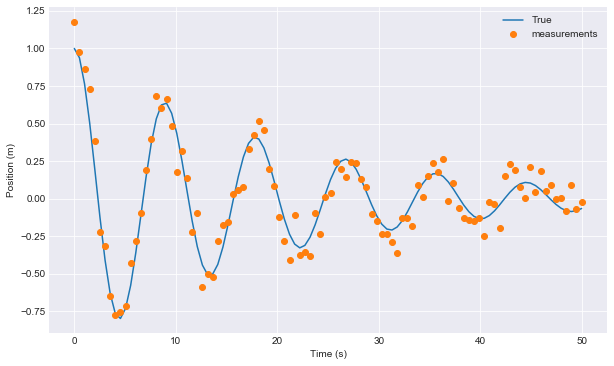

In [3]:
# Code to generate the noisy measurements
# Number of Timesteps
T = 100
np.random.seed(0)

# Textbook solution to Unforced Mass-Spring-Damper Harmonic Oscillator
def MSD(t,m,k,c,y0,v0):
  omega = np.sqrt(4*m*k-c**2)/(2*m)
  B = (v0+y0*c/(2*m))/omega 
  phi = np.arctan(y0/B)
  A = np.sqrt(y0**2 +  B**2)
  y = A*np.exp(-c*t/(2*m))*np.sin(omega*t+phi)
  return y

# Simulate the true system:
time_vec = np.linspace(0, 50, T)
ytrue = MSD(time_vec, 
            m=10, 
            k=5,
            c=1,
            y0=1,
            v0=0)

# Add Measurement Noise
measurements = ytrue + 0.1*np.random.randn(T)

plt.figure(figsize=(10, 6))
plt.plot(time_vec, ytrue, label='True')
plt.plot(time_vec, measurements,'o', label='measurements')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.show()


# Task1: Build the Probabilistic Model

Using the probabilistic programming language of your choice, build a probabilistic model of the position as a function of time, with the following prior beliefs about the other system parameters:
$$
P(\mathbf{y},m,k,c,v_0|T) = \sum_{t \in T} {\cal N}(y_t | \hat{y}(t,m,k,c,v_0),\sigma^2)P(m)P(c)P(k)P(v_0)P(sigma)
$$
where
$$
\begin{eqnarray}
  P(m)&\sim & {\cal N}(\mu_m=10, \sigma_m = 0.01) \\
  P(k)&\sim & {\cal N}(\mu_k=10, \sigma_k = 5)  \\
  P(c)&\sim & {\cal N}(\mu_c=5, \sigma_c = 2)  \\
  P(v_0)&\sim & {\cal N}(\mu_{v_0}=0, \sigma_{v_0} = 5)  \\
  P(sigma )&\sim & \mathrm{Gamma}(\alpha = 0.2, \beta = 1) \\
\end{eqnarray}
$$

While this seems like perhaps a complicated model, using probabilistic programming this basically means:

1. Instantiate probabilistic variables `m`,`c`,`k`, `v0` and `sigma` with the appropriate Normal and Gamma prior distributions.
2. Use them when computing the dynamics solution above.
3. Set the output variable `y` to be the observed variable using `measurements` as the observations.
4. Sample the model with N=15K samples. (e.g., I would suggest the NUTS sampler with 15K samples and using around 2000 tuning samples). Use at least two chains for comparison sake later.

Hint: If you have issues getting your sampling chains to converge, you can try: (1) increasing the number of samples, (2) increasing the number of tuning samples you allow `tuning = ####`, or (3) increasing the target acceptance rate for the MCMC samples (`target_accept=0.95` or `.99`, etc.). You can also increase the number of independent chains via `chains=3` or `4` or other numbers, though I would try increasing the number of samples first.

Hint 2: You will notice that our prior belief about the mass is really tight ($\sigma_m=0.01$). This is on purpose and not a typo. Task 3 will explore what happens if this is not the case. In more realistic problems, we may not know the mass with such accuracy, though for this task we will assume that we do.

Hint 3: Particularly eagle-eyed students may question the use of, e.g., the Normal distribution on parameters like Mass or damping coefficient, etc., since, technically, that could mean there is a probability of getting a negative mass or stiffness or damping etc. which is not physically sound and so forth. This is true, and it would be in fact far more reasonable to pick a distribution on the positive reals, such as the Log-Normal, Half-Cauchy, Truncated Normal, Exponential, or others. Feel free to do so if you like, but for simplicity sake I am asking everyone to do Normals for now.


In [4]:
import pymc3 as pm
from pymc3 import Model, Normal, Gamma

In [9]:
basic_model = Model()
with basic_model:
    p_m = pm.Normal('p_m',mu = 10,sd = 0.01)
    p_k = pm.Normal('p_k',mu = 10,sd = 5)
    p_c = pm.Normal('p_c',mu = 5,sd = 2)
    p_int_velocity = pm.Normal('p_int_velocity',mu =0, sd = 5)
    p_sig = pm.Gamma('p_sigma', alpha = 0.2, beta =1)
    
    y_train = MSD(time_vec, p_m, p_k, p_c, y0 =1, v0 = 0)
    
    # Add Measurement Noise
    measurements = y_train + 0.1*np.random.randn(T)
    y_obs = pm.Normal('y_obs',sd = p_sig, observed = measurements)

In [13]:
from pymc3 import find_MAP
from scipy import optimize
map_estimate = pm.find_MAP(model=basic_model, fmin=optimize.fmin_powell)
map_estimate

logp = 29.275:   6%|███▍                                                          | 281/5000 [00:00<00:01, 3758.04it/s]

Optimization terminated successfully.
         Current function value: -29.275003
         Iterations: 4
         Function evaluations: 281


{'p_m': array(9.99980599),
 'p_k': array(20.77532986),
 'p_c': array(9.4299611),
 'p_int_velocity': array(5.44941961e-11),
 'p_sigma_log__': array(-1.79662428),
 'p_sigma': array(0.16585783)}

In [15]:
from pymc3 import NUTS, sample

with basic_model:
    start = pm.find_MAP(fmin = optimize.fmin_powell)
    step = NUTS(scaling = start)
    trace = sample(15000, step = step, start = start, chains=2, cores=2, tune=2000)

logp = 29.275:   6%|███▍                                                          | 281/5000 [00:00<00:00, 4776.10it/s]


Optimization terminated successfully.
         Current function value: -29.275003
         Iterations: 4
         Function evaluations: 281


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_sigma, p_int_velocity, p_c, p_k, p_m]
Sampling 2 chains: 100%|████████████████████████████████████████████████████| 34000/34000 [00:17<00:00, 1906.53draws/s]


# Task 2: Inspect the model

Now that you have your samples, go ahead and inspect the output of the probabilistic program. Specifically:

## Plot the trace plots of the uncertain parameters.




array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026099791A90>,
      dtype=object)

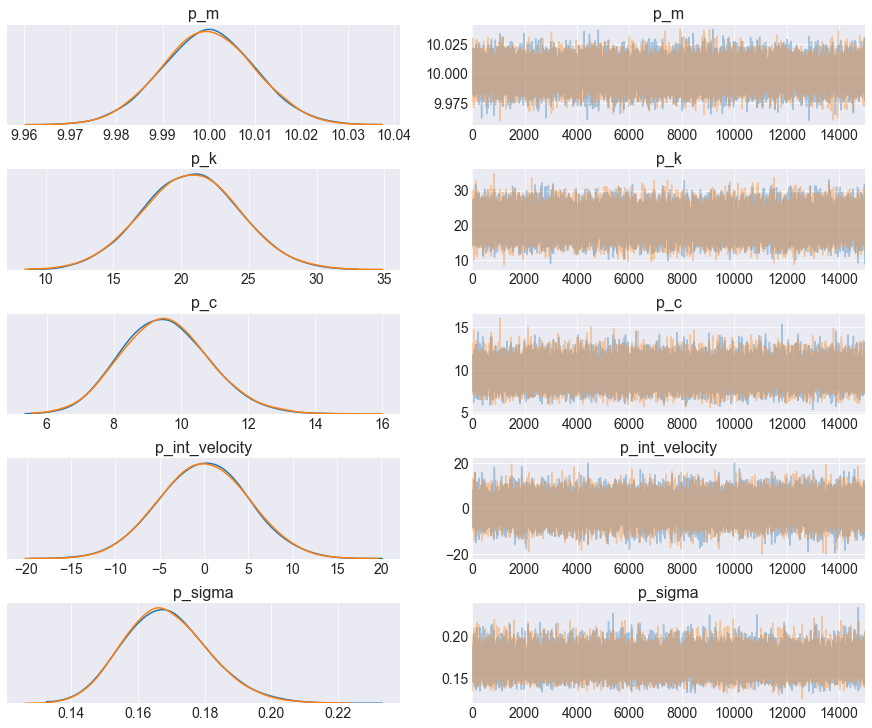

In [21]:
from pymc3 import traceplot
pm.traceplot(trace)

Q: Do the different chains produce similar estimates of the parameters? Has the model seemed to converge? What evidence are you using to assess either answer?

A: Yes. The model has seemed to converge. Because the value of each parameter form the plot seems consistent with the numerical value.



## Provide the Summary statistics of the uncertain parameters
That is, compute the mean, and 95% posterior interval for the main system parameters (mass, spring constant, damping).

In [23]:
from pymc3 import summary
def trace_quantiles(x):
    return pd.DataFrame(pm.quantiles(x, [5, 50, 95]))

In [24]:
import pandas as pd
pm.summary(trace, stat_funcs=[trace_quantiles])

,5,50,95
p_m,9.983422,9.999866,10.016440
p_k,14.957969,20.770556,26.599672
p_c,7.519895,9.501779,11.738166
p_int_velocity,-8.209887,0.030202,8.253306
p_sigma,0.149258,0.167958,0.190645


In [25]:
pm.summary(trace)

C:\Users\Haixiang\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p_m,9.999857,0.009980,0.000043,9.980265,10.019368,45334.893232,0.999997
p_k,20.770683,3.523493,0.018885,13.790040,27.580217,39249.827474,0.999967
p_c,9.543732,1.288326,0.007114,7.108345,12.130884,36546.495163,1.000028
p_int_velocity,0.024082,5.000157,0.023024,-9.624760,9.887483,44972.917428,0.999973
p_sigma,0.168689,0.012651,0.000078,0.145013,0.194399,31234.645066,0.999992


Q: Given that you know the true system parameters that generate the data (seen in the code at the top that generated the measurements), do these estimates seem reasonable? Do their 95% credible intervals include the correct parameters? Are any unreasonable? Explain why.

A: They are all in the resonable range.

## Plot the 95% CI bound on the predicted true function
Using the samples you gathered while running your probabilistic program, produce a plot that compares (with time on the x-axis):

1. The provided measurements (`measurements`)
2. The true function (`ytrue`)
3. The mean predicted function (from your model)
4. The 95% CI upper bound on the function over time (from your model)
5. The 95% CI lower bound on the function over time (from your model).

Ideally, your 95% CI should contain the true function, if your probabilistic program is well-calibrated (i.e., has an appropriate measure of its own uncertainty).

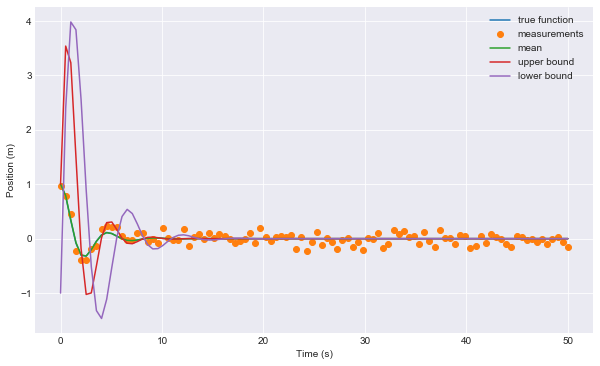

In [26]:
y_int = MSD(time_vec, 
            m = 9.99980599, 
            k = 20.77532986,
            c = 9.4299611,
            y0 = 1,
            v0 = 5.44941961e-11)
y_mean = MSD(time_vec,
             m = 9.999857,
             k = 20.770683, 
             c = 9.543732,
             y0 = 1,
             v0 = 0.024082)
y_upper = MSD(time_vec,
             m = 10.016440,
             k = 26.599672, 
             c = 11.738166,
             y0 = 1,
             v0 = 8.253306)
y_lower = MSD(time_vec,
             m = 9.983422,
             k = 14.957969, 
             c = 7.519895,
             y0 = 1,
             v0 = -8.209887)            



measurements_int = y_int + 0.1*np.random.randn(T)

plt.figure(figsize=(10, 6))
plt.plot(time_vec, y_int, label='true function')
plt.plot(time_vec, measurements_int,'o', label='measurements')
plt.plot(time_vec, y_mean, label='mean')
plt.plot(time_vec, y_upper, label='upper bound')
plt.plot(time_vec, y_lower, label='lower bound')

plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.show()

## Plot the posterior covariance between the system parameters

Specifically, plot the pairwise joint probability density between the posterior distributions of the variables for mass, spring constant, and damping. You can do this by plotting for each point on the trace, the pairwise relationship between m vs k, k vs c, and m vs c.

Hint: Using a function like pairplot will be useful here, since such functions draw joint probability points automatically.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002609D876668>,
      dtype=object)

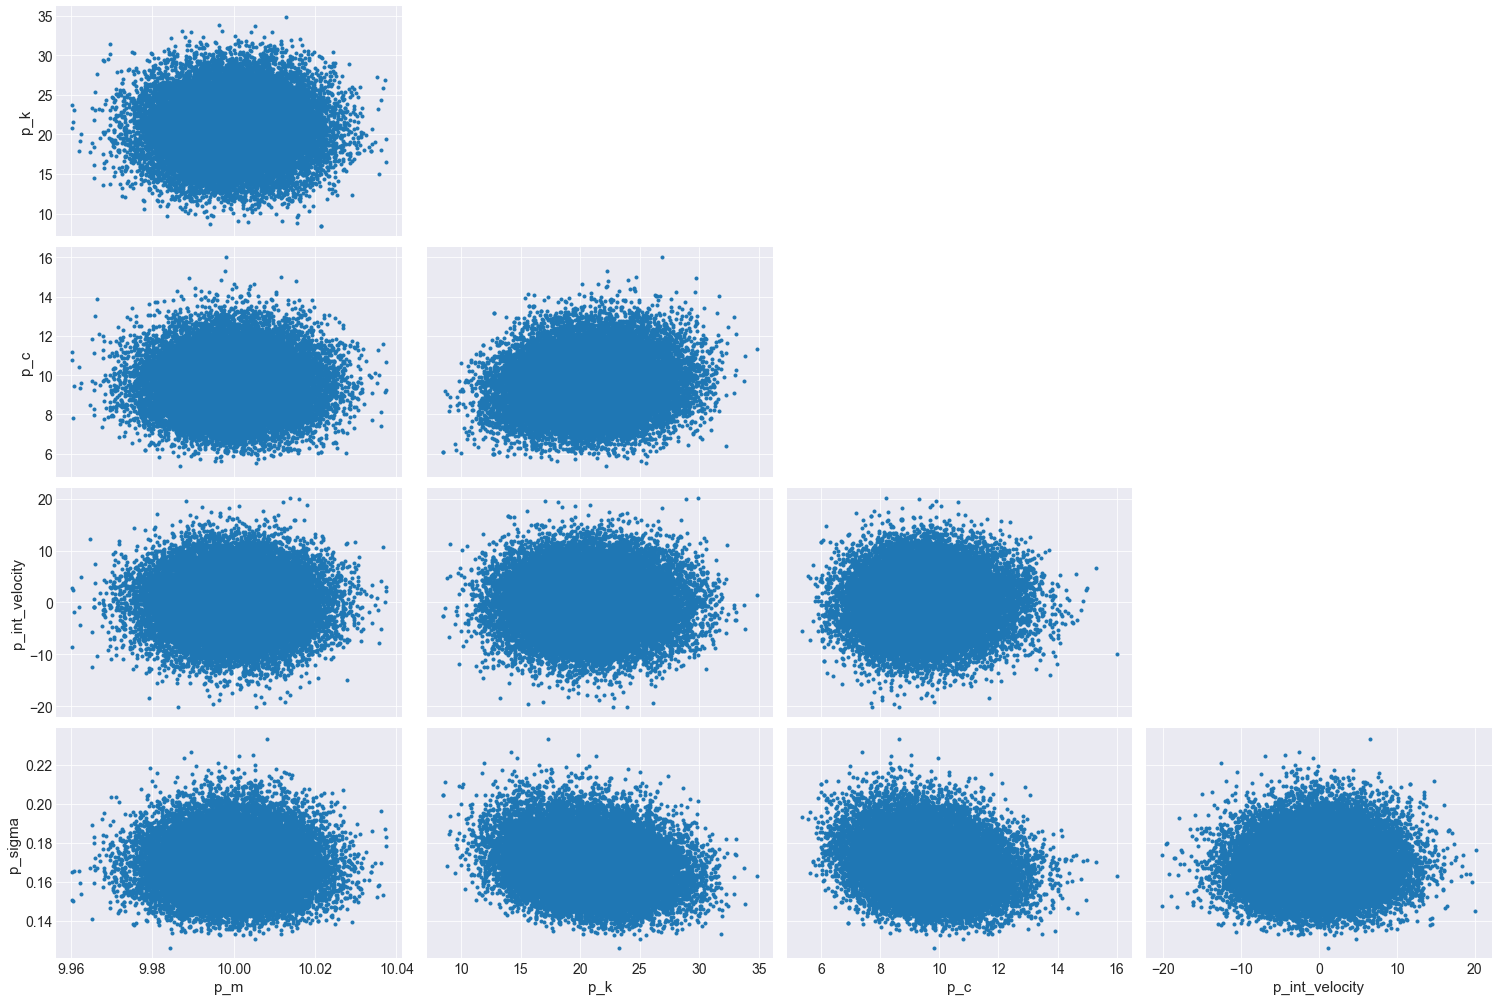

In [27]:
pm.plots.pairplot(trace)

Q: What do you notice, if anything about the covariance between m, c, and k?

A:  The correlation between c and k is positive.

# (743 Only) Task 3: Uncertain mass

Above, we assumed that we had a fairly good prior idea of the mass of the system. What if we were less sure and wanted to try to infer the mass as well?

To see how this would turn out, re-run your original model from above, except this time make the prior belief about the mass less certain -- perhaps you are not sure exactly how much the mass might weigh.... That is, instead of making your prior distribution on the mass $P(m) \sim  {\cal N}(\mu_m=10, \sigma_m = 0.01)$, *instead* increase the standard deviation to $\sigma_m = 3$ -- a significant increase in prior uncertainty (e.g., the mass could now range anywhere from around 1-ish to 20-ish.

Re-Run your probabilistic program from above, and include some of the same outputs such as (1) the trace plot, (2) the summary statistics of the parameters, and (3) the posterior covariance between m, c, and k. Note any changes. Likewise, re-plot the predicted displacement vs t as you did above (including the upper and lower bounds). Note any changes.

Warning: Convergence on these sampling steps may be signficantly slower than what you saw for Task 2, so budget waiting time accordingly.


$\sigma_m = 3$ is not convergent. So I change it to $3/2$

In [43]:
new_model = Model()
with new_model:
    p_m = pm.Normal('p_m',mu = 10,sd = 1.5)
    p_k = pm.Normal('p_k',mu = 10,sd = 5)
    p_c = pm.Normal('p_c',mu = 5,sd = 2)
    p_int_velocity = pm.Normal('p_int_velocity',mu =0, sd = 5)
    p_sig = pm.Gamma('p_sigma', alpha = 0.2, beta =1)
    
    y_train = MSD(time_vec, p_m, p_k, p_c, y0 =1, v0 = 0)
    
    # Add Measurement Noise
    measurements = y_train + 0.1*np.random.randn(T)
    y_obs = pm.Normal('y_obs',sd = p_sig, observed = measurements)

In [44]:
map_estimate = pm.find_MAP(model=new_model, fmin=optimize.fmin_powell)
print(map_estimate)

C:\Users\Haixiang\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
C:\Users\Haixiang\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:102: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = 26.108:   6%|███▌                                                          | 288/5000 [00:00<00:00, 4731.46it/s]

Optimization terminated successfully.
         Current function value: -26.108969
         Iterations: 4
         Function evaluations: 288
{'p_m': array(5.78994467), 'p_k': array(16.49740293), 'p_c': array(8.22174396), 'p_int_velocity': array(-1.28242149e-07), 'p_sigma_log__': array(-1.82789151), 'p_sigma': array(0.16075216)}


In [45]:
with new_model:
    start = pm.find_MAP(fmin = optimize.fmin_powell)
    step = NUTS(scaling = start)
    trace_new = sample(15000, step = step, start = start, chains=2, cores=2, tune=2000)

logp = 26.108:   6%|███▌                                                          | 288/5000 [00:00<00:00, 4891.59it/s]


Optimization terminated successfully.
         Current function value: -26.108969
         Iterations: 4
         Function evaluations: 288


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_sigma, p_int_velocity, p_c, p_k, p_m]
Sampling 2 chains: 100%|████████████████████████████████████████████████████| 34000/34000 [00:21<00:00, 1548.62draws/s]
There were 1928 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1802 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000260A44C8898>,
      dtype=object)

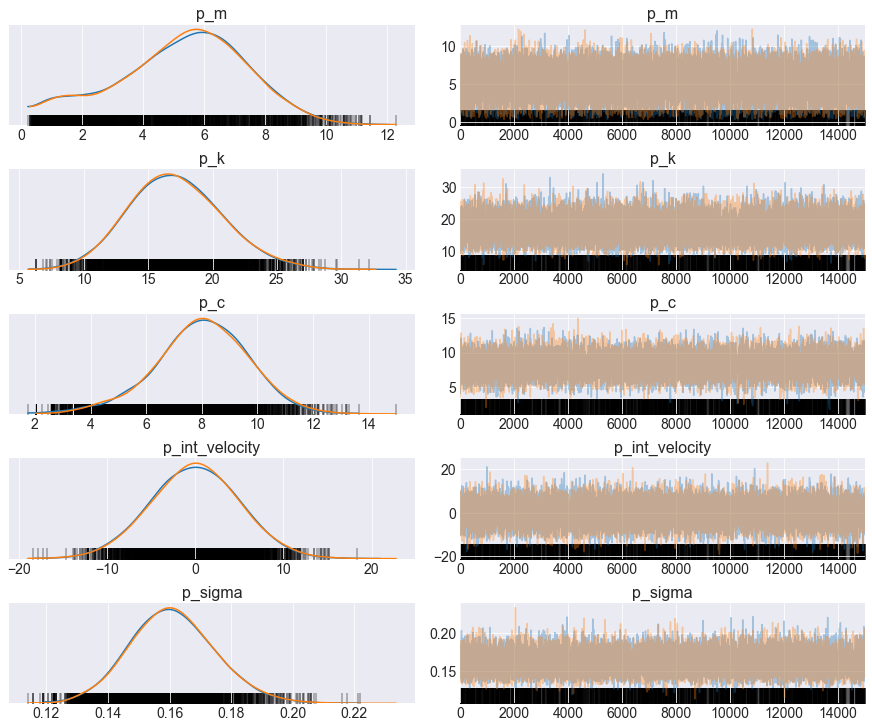

In [46]:
pm.traceplot(trace_new)

In [47]:
def trace_quantiles(x):
    return pd.DataFrame(pm.quantiles(x, [5, 50, 95]))
pm.summary(trace_new, stat_funcs=[trace_quantiles])


,5,50,95
p_m,1.328232,5.470656,8.517103
p_k,11.598088,17.007326,23.385762
p_c,5.099064,8.063133,10.588454
p_int_velocity,-8.223919,0.023270,8.176581
p_sigma,0.139561,0.160641,0.184426


In [48]:
pm.summary(trace_new)

C:\Users\Haixiang\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p_m,5.264913,2.115026,0.030350,0.637119,8.707446,4902.142016,0.999968
p_k,17.180427,3.588567,0.025926,10.301936,24.299985,16602.204393,0.999967
p_c,8.005433,1.661581,0.026676,4.586150,11.273698,3996.646024,1.000129
p_int_velocity,0.010249,4.984173,0.036397,-9.941543,9.508651,20244.194030,1.000007
p_sigma,0.161112,0.013623,0.000144,0.133486,0.187071,8384.318392,1.000036


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000260AEDE5828>,
      dtype=object)

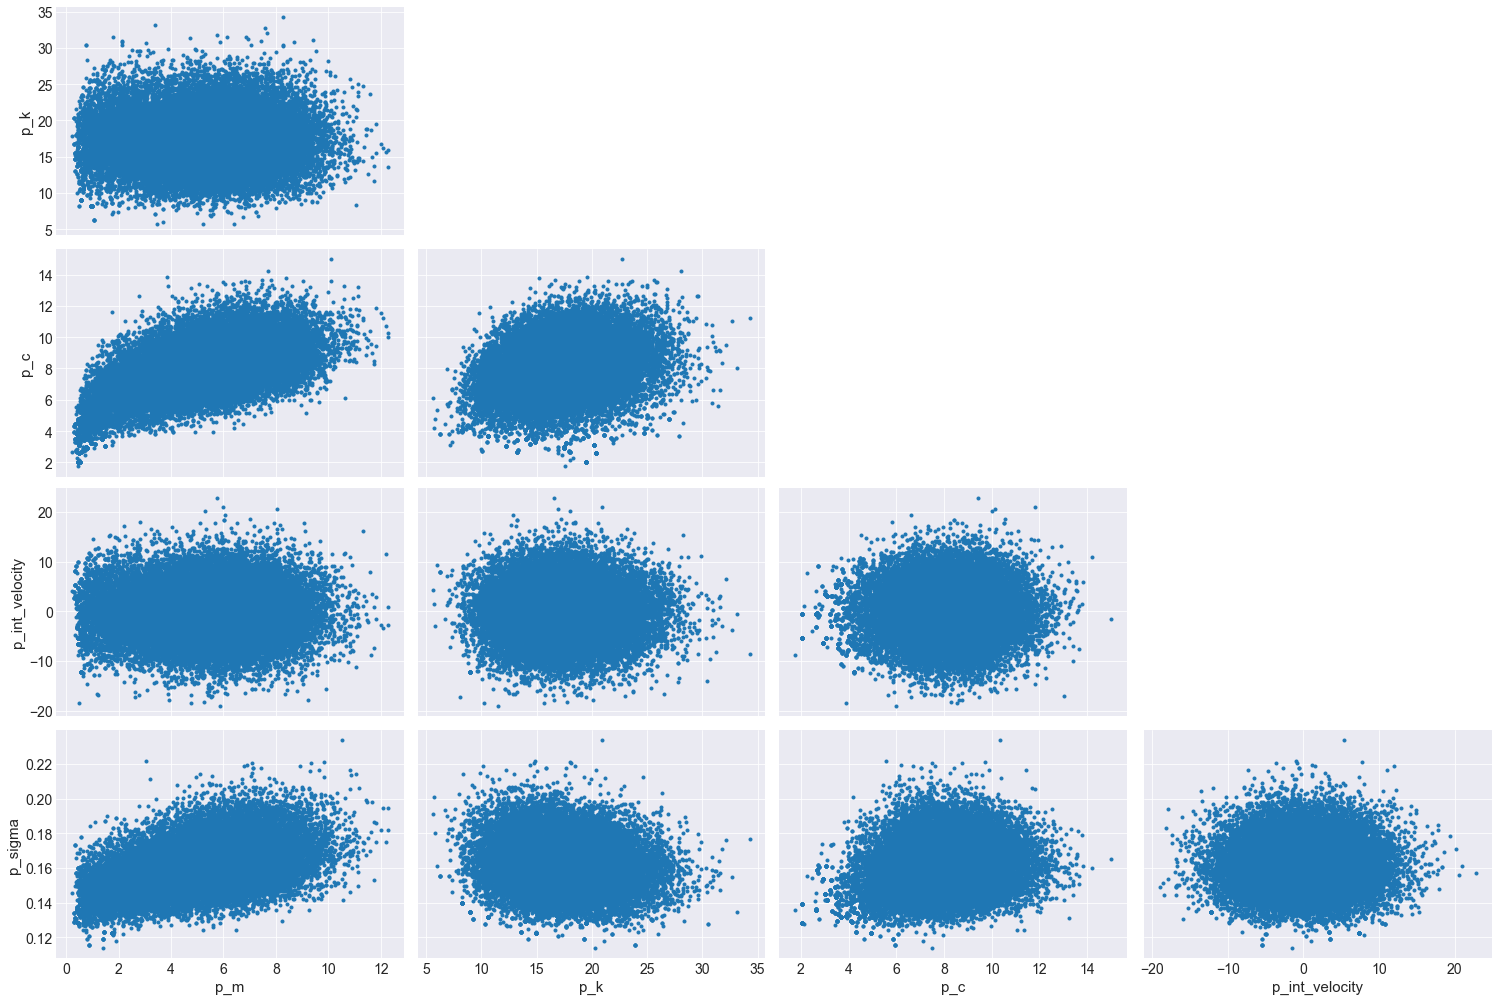

In [49]:
pm.plots.pairplot(trace_new)

Q: Do you get the same results trace plot or summary statistics as before? If not, what has changed?

A:Yes.

Q: How did the posterior covariance between m, k, and c change? What do you think is causing this change and why would this cause possible problems for estimating the mass, spring constant, and damping?

A:The value of m,c and k decreased. The correlation between c,sigma and m turns to be positive. It might because the standard deviation of m has increased significantly.

Hint: To help understand the above, see the below code where we plot the behavior of four different (deterministic) systems:

1. m = 10, k = 5, c = 1
2. m = 20, k = 10, c = 2
3. m = 30, k = 15, c = 3
4. m = 30, k = 20, c = 3

What is going on here? Look at the formulas above for $y$, $B$, and $\omega$. What happens when we change things in a fashion similar to cases 1-3? How might this affect the likelihood $P(\mathbf{y},m,k,c,v_0|T)$? What might this mean for our estimates of the uncertain parameters m, c, and k? This may help you think through your answer to the above question.


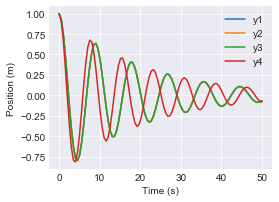

In [50]:
# Plot a few example systems with different masses, spring constants, and damping
y1 = MSD(time_vec, 
           m=10, k=5, c=1, y0=1, v0=0)
y2 = MSD(time_vec, 
           m=20, k=10, c=2, y0=1, v0=0)
y3 = MSD(time_vec, 
           m=30, k=15, c=3, y0=1, v0=0)

y4 = MSD(time_vec, 
           m=30, k=20, c=3, y0=1, v0=0)


plt.figure(figsize=(4, 3))
plt.plot(time_vec, y1, label='y1')
plt.plot(time_vec, y2, label='y2')
plt.plot(time_vec, y3, label='y3')
plt.plot(time_vec, y4, label='y4')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.show()